# Temperature lapse rates

In [1]:
# modules
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [6]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'forcing_lapse_rates.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Find catchment-average and temperature-lapsed forcing files

In [7]:
# Forcing files as produced by EASYMORE
forcing_easymore_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [8]:
# Specify default path if needed
if forcing_easymore_path == 'default':
    forcing_easymore_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_easymore_path = Path(forcing_easymore_path) # make sure a user-specified path is a Path()

In [9]:
# Find the files
_,_,forcing_files_esmr = next(os.walk(forcing_easymore_path))
forcing_files_esmr.sort()

In [10]:
# Location for SUMMA-ready files
forcing_summa_path = read_from_control(controlFolder/controlFile,'forcing_summa_path')

In [11]:
# Specify default path if needed
if forcing_summa_path == 'default':
    forcing_summa_path = make_default_path('forcing/4_SUMMA_input') # outputs a Path()
else:
    forcing_summa_path = Path(forcing_summa_path) # make sure a user-specified path is a Path()

In [12]:
# Find the files
_,_,forcing_files_summa = next(os.walk(forcing_summa_path))
forcing_files_summa.sort()

#### Find where the catchment/forcing intersection is

In [13]:
# Intersected shapefile path. Name is set by EASYMORE as [prefix]_intersected_shapefile.shp
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')

In [14]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [15]:
# Make the file name
domain = read_from_control(controlFolder/controlFile,'domain_name')
intersect_name = domain + '_intersected_shapefile.csv' # can also be .shp, but using the .csv is easier on memory

#### Find where the catchment/DEM intersection is

In [16]:
# Find location of DEM intersection for shapes and elevation
elev_catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

In [17]:
# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

#### Find where the ERA5 geopotential data is

In [18]:
# Find file path
geo_path = read_from_control(controlFolder/controlFile,'forcing_geo_path')

In [19]:
# Specify the default path if required
if geo_path == 'default':
    geo_path = make_default_path('forcing/0_geopotential')
else: 
    geo_path = Path(geo_path) # ensure Path() object 

In [20]:
# Specify the filename
geo_name = 'ERA5_geopotential.nc'

#### Reproduce the lapse code

In [21]:
# Load the intersection file
topo_data = pd.read_csv(intersect_path/intersect_name) 

In [22]:
# Find hruId name in user's shapefile
hru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')
gru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')

In [23]:
# Specify the column names
# Note that column names are truncated at 10 characters in the ESRI shapefile, but NOT in the .csv we use here
gru_ID         = 'S_1_' + gru_ID_name # EASYMORE prefix + user's hruId name
hru_ID         = 'S_1_' + hru_ID_name # EASYMORE prefix + user's hruId name
forcing_ID     = 'S_2_ID'             # fixed name assigned by EASYMORE
catchment_elev = 'S_1_elev_mean'      # EASYMORE prefix + name used in catchment+DEM intersection step
forcing_elev   = 'S_2_elev_m'         # EASYMORE prefix + name used in ERA5 shapefile generation
weights        = 'weight'             # EASYMORE feature

In [24]:
# Define the lapse rate
lapse_rate = 0.0065 # [K m-1]

In [25]:
# Calculate weighted lapse values for each HRU 
# Note that these lapse values need to be ADDED to ERA5 temperature data
topo_data['lapse_values'] = topo_data[weights] * lapse_rate * \
    (topo_data[forcing_elev] - topo_data[catchment_elev]) # [K]

In [26]:
# Find the total lapse value per basin; i.e. sum the individual contributions of each HRU+ERA5-grid overlapping part
lapse_values = topo_data.groupby([gru_ID,hru_ID]).lapse_values.sum().reset_index()

In [27]:
# Sort and set hruID as the index variable
lapse_values = lapse_values.sort_values(hru_ID).set_index(hru_ID)

In [28]:
# Close the main file
del topo_data # hopefully this saves some RAM but this is apparently not so straightforward in Python.. Can't hurt

#### Prepare plotting data (elevation, lapse rates)

In [29]:
# load catchment with DEM
catchment = gpd.read_file(elev_catchment_path/elev_catchment_name)

In [30]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = catchment[[gru_ID_name,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=gru_ID_name) # Dissolve HRU delineation

In [31]:
# Add lapse rates to catchment shapefile
catchment = catchment.set_index(hru_ID_name) # ensure that HRU_ID is the index
catchment['lapse_rate'] = lapse_values['lapse_values'] # merge with the lapse rate dataframe

#### Prepare plotting data (geopotential -> ERA5 elevation)

In [32]:
# Open the geopotential data file
geo = xr.open_dataset( geo_path / geo_name ).isel(time=0)
#geo = xr.open_dataset( geo_path / 'ERA5_geopotential_original.nc' ).isel(time=0)

In [33]:
# Define the gravitational acceleration constant
g = 9.80665 # [m s-2]

In [34]:
# Make a new variable
geo['elev'] = geo['z'] / g

#### Prep plotting data (old and new forcing)

In [38]:
# select the files
idx = 0
old_file = forcing_files_esmr[idx]
new_file = forcing_files_summa[idx]

In [39]:
# open old and new file
forcing_old = xr.open_dataset(forcing_easymore_path / old_file)
forcing_new = xr.open_dataset(forcing_summa_path / new_file)

In [40]:
# Prepare dataframes with temperature for a given time
time = 0
old_temp = {'airtemp': forcing_old['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}
new_temp = {'airtemp': forcing_new['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}

In [41]:
# Make dataframes
df_old_temp = pd.DataFrame(old_temp)
df_new_temp = pd.DataFrame(new_temp)

In [42]:
# Set indices
df_old_temp = df_old_temp.set_index('hruId')
df_new_temp = df_new_temp.set_index('hruId')

In [43]:
# Merge with catchment shapefile
catchment['old_T'] = df_old_temp['airtemp']
catchment['new_T'] = df_new_temp['airtemp']

#### Figure

In [44]:
# plot settings
cmap_elev = 'terrain'
cmap_lapse = 'coolwarm'

In [45]:
# scaling
vmin_elev,vmax_elev = catchment['elev_mean'].min(),catchment['elev_mean'].max()
vmin_rate,vmax_rate = -5,5
vmin_temp = min(df_new_temp.min().values,df_old_temp.min().values)
vmax_temp = max(df_new_temp.max().values,df_old_temp.max().values)
#vmin_temp,vmax_temp = 252,262 # these ranges match those in the grid-to-hru figure

In [46]:
# Get the forcing time
time_str_old = forcing_old['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values
time_str_new = forcing_new['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values

<ipython-input-50-2e00d881fb38>:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


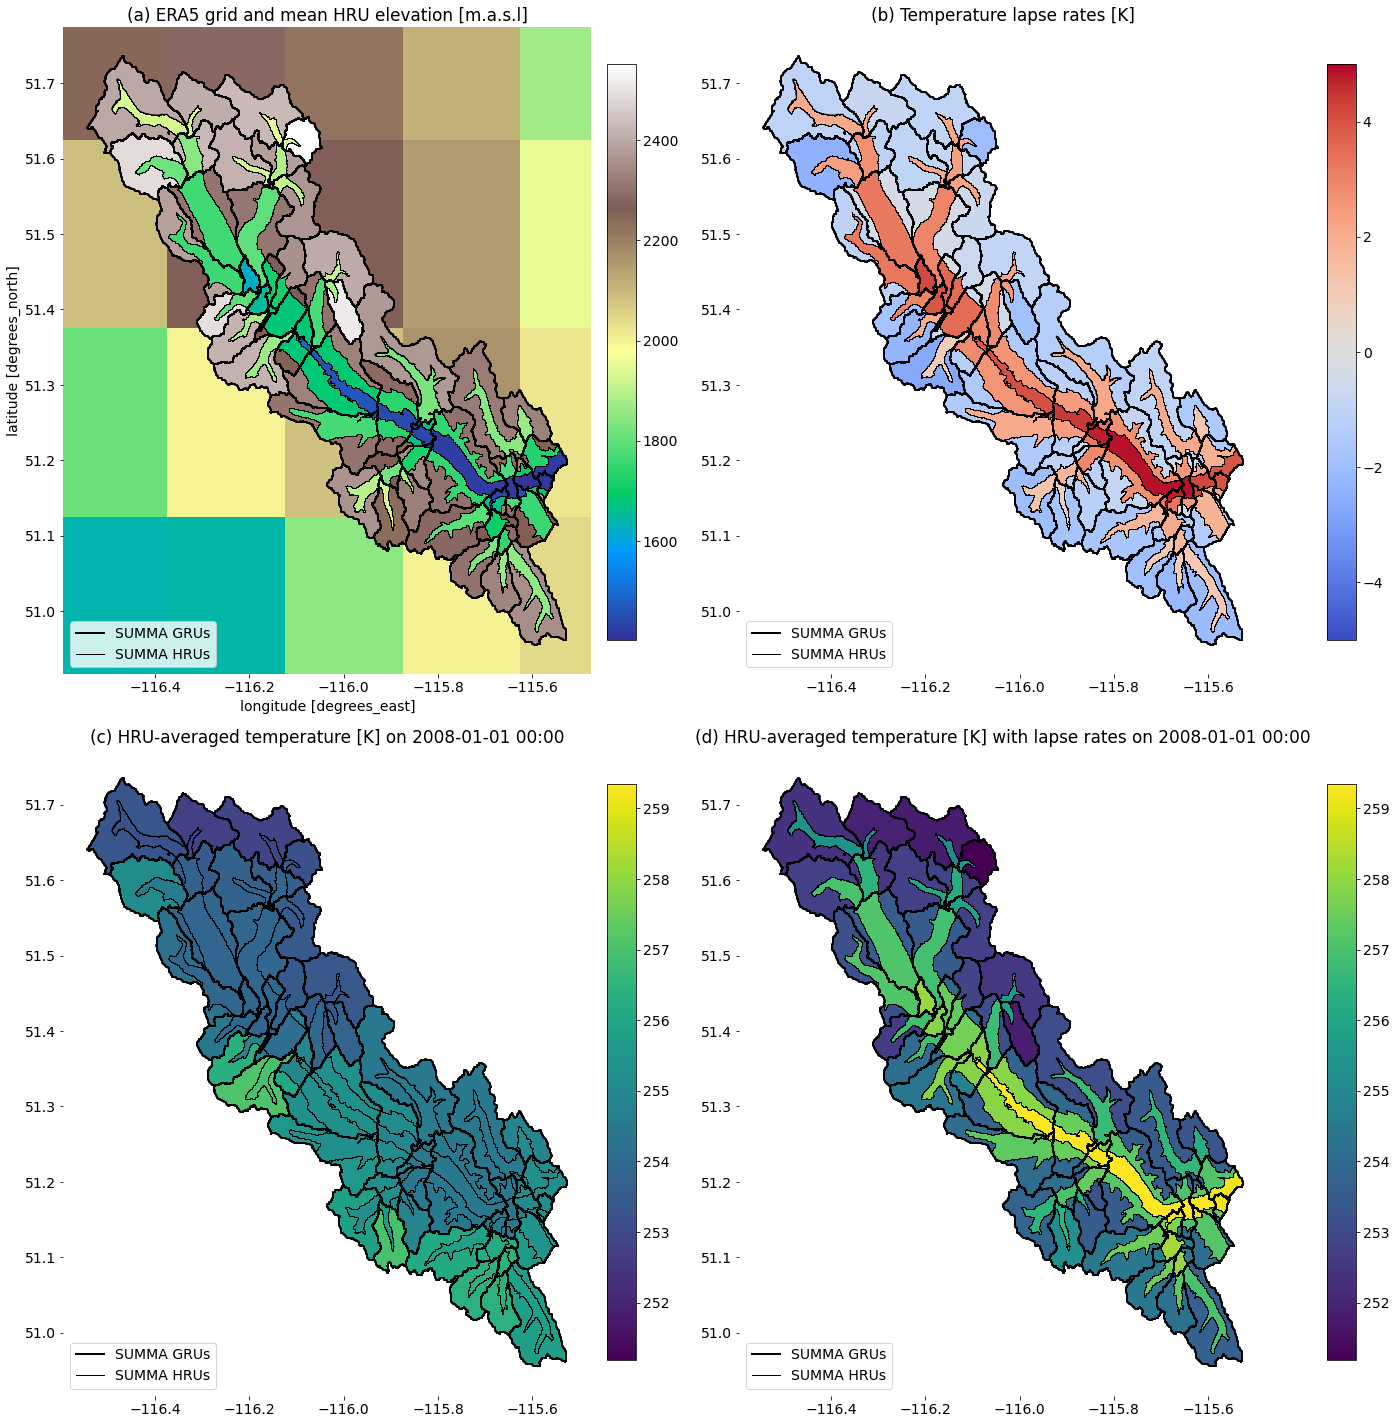

In [50]:
# figure
fig, axs = plt.subplots(2,2,figsize=(20,20))
axs = axs.flatten()
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

# --- elevation
axId = 0

# Data
geo['elev'].plot(ax=axs[axId], cmap = cmap_elev, add_colorbar=False, vmin=vmin_elev, vmax=vmax_elev)
catchment.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False, vmin=vmin_elev, vmax=vmax_elev)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.55, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin_elev, vmax=vmax_elev))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) ERA5 grid and mean HRU elevation [m.a.s.l]');
axs[axId].set_frame_on(False)


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='lapse_rate',edgecolor='k', cmap = cmap_lapse, legend=False, vmin=-5, vmax=5)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.55, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap_lapse, norm=plt.Normalize(vmin=vmin_rate, vmax=vmax_rate))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Temperature lapse rates [K]');
axs[axId].set_frame_on(False)

# --- reset axes on first plot
xlim = axs[axId].get_xlim()
ylim = axs[axId].get_ylim()
axId = 0
axs[axId].set_xlim(xlim)
axs[axId].set_ylim(ylim)

# ---------------------------------------------------------------------------------------------------------------
# --- old forcing
axId = 2

# Data
catchment.plot(ax=axs[axId], column='old_T',edgecolor='k', legend=False, vmin=vmin_temp, vmax=vmax_temp)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.05, 0.02, 0.4])
vmin = min(df_new_temp.min().values,df_old_temp.min().values)
vmax = max(df_new_temp.max().values,df_old_temp.max().values)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_temp, vmax=vmax_temp))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(c) HRU-averaged temperature [K] on {}'.format(time_str_old))
axs[axId].set_frame_on(False)


# --- new forcing
axId = 3

# Data
catchment.plot(ax=axs[axId], column='new_T',edgecolor='k', legend=False, vmin=vmin_temp, vmax=vmax_temp)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.05, 0.02, 0.4])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_temp, vmax=vmax_temp))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(d) HRU-averaged temperature [K] with lapse rates on {}'.format(time_str_new))
axs[axId].set_frame_on(False)

# save
plt.tight_layout()
plt.savefig(fig_path/fig_name, bbox_inches='tight')